In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
cv2.ocl.setUseOpenCL(False)
import warnings
warnings.filterwarnings('ignore')

In [2]:
feature_extraction_algo = 'sift'

feature_to_match = 'bf'

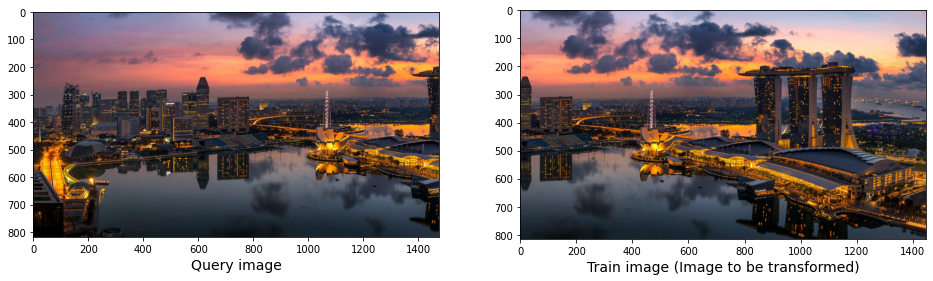

In [3]:
# Make sure that the train image is the image that will be transformed
qury='query.jpg'
tra='train.jpg'

train_photo = cv2.imread(tra)

# OpenCV defines the color channel in the order BGR 
# Hence converting to RGB for Matplotlib
train_photo = cv2.cvtColor(train_photo,cv2.COLOR_BGR2RGB)

# converting to grayscale
train_photo_gray = cv2.cvtColor(train_photo, cv2.COLOR_RGB2GRAY)

# Do the same for the query image 
query_photo = cv2.imread(qury)
query_photo = cv2.cvtColor(query_photo,cv2.COLOR_BGR2RGB)
query_photo_gray = cv2.cvtColor(query_photo, cv2.COLOR_RGB2GRAY)

# Now view/plot the images
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(query_photo, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(train_photo, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.savefig("./_"+'.jpeg', bbox_inches='tight', dpi=300, optimize=True, format='jpeg')

plt.show()

In [4]:
def select_descriptor_methods(image, method=None):    
    
    assert method is not None, "Please define a feature descriptor method. accepted Values are: 'sift', 'surf'"
    
    if method == 'sift':
        descriptor = cv2.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    (keypoints, features) = descriptor.detectAndCompute(image, None)
    
    return (keypoints, features)

In [5]:
keypoints_train_img, feature_train_img = select_descriptor_methods(train_photo_gray, method=feature_extraction_algo)

keypoints_query_img, feature_query_img = select_descriptor_methods(query_photo_gray, method=feature_extraction_algo)

In [7]:
for keypoint in keypoints_query_img:
    x,y = keypoint.pt
    size = keypoint.size 
    orientation = keypoint.angle
    response = keypoint.response 
    octave = keypoint.octave
    class_id = keypoint.class_id


print (x,y)
 
print(size)

print(orientation)

print(response)
print(octave)
print(class_id)

1472.0048828125 116.56388092041016
2.002023696899414
98.62557983398438
0.017185261473059654
7864831
-1


In [8]:
print(len(keypoints_query_img))

feature_query_img.shape

4921


(4921, 128)

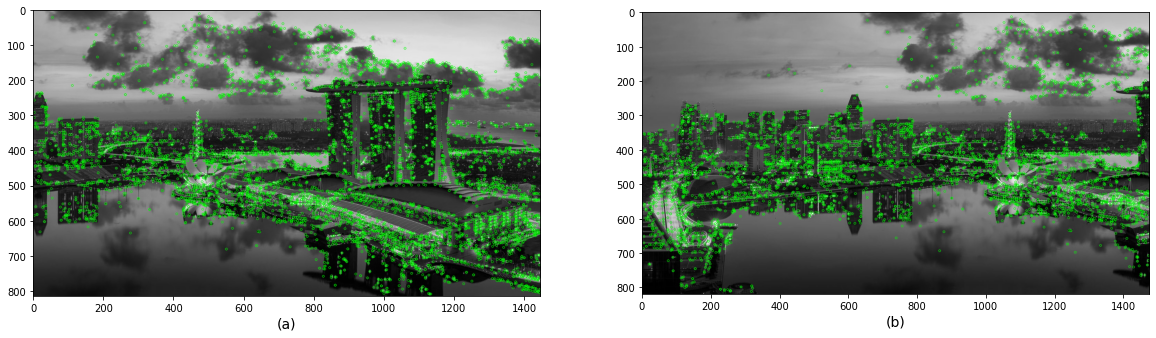

In [9]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)

ax1.imshow(cv2.drawKeypoints(train_photo_gray, keypoints_train_img, None, color=(0,255,0)))

ax1.set_xlabel("(a)", fontsize=14)

ax2.imshow(cv2.drawKeypoints(query_photo_gray,keypoints_query_img,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.savefig("./output/" + feature_extraction_algo + "_features_img_"+'.jpeg', bbox_inches='tight', 
            dpi=300, optimize=True, format='jpeg')
plt.show()

In [10]:
def create_matching_object(method,crossCheck):
    "Create and return a Matcher Object"
    
    # For BF matcher, first we have to create the BFMatcher object using cv2.BFMatcher(). 
    # It takes two optional params. 
    # normType - It specifies the distance measurement
    # crossCheck - which is false by default. If it is true, Matcher returns only those matches 
    # with value (i,j) such that i-th descriptor in set A has j-th descriptor in set B as the best match 
    # and vice-versa. 
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [11]:
def key_points_matching(features_train_img, features_query_img, method):
    bf = create_matching_object(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(features_train_img,features_query_img)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches with Brute force):", len(rawMatches))
    return rawMatches

In [12]:
def key_points_matching_KNN(features_train_img, features_query_img, ratio, method):
    bf = create_matching_object(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(features_train_img, features_query_img, k=2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

Drawing: bf matched features Lines
Raw matches with Brute force): 2695


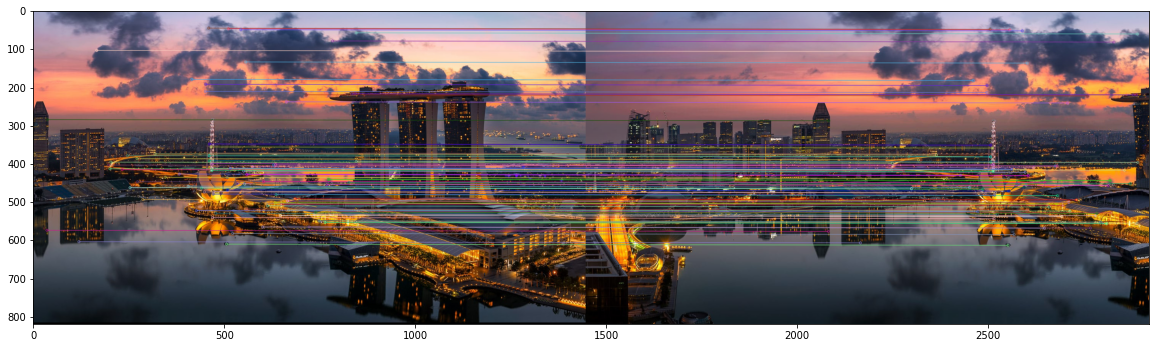

In [13]:
print("Drawing: {} matched features Lines".format(feature_to_match))

fig = plt.figure(figsize=(20,8))

if feature_to_match == 'bf':
    matches = key_points_matching(feature_train_img, feature_query_img, method=feature_extraction_algo)
    
    mapped_features_image = cv2.drawMatches(train_photo,keypoints_train_img,query_photo,keypoints_query_img,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Now for cross checking draw the feature-mapping lines also with KNN
elif feature_to_match == 'knn':
    matches = key_points_matching_KNN(feature_train_img, feature_query_img, ratio=0.75, method=feature_extraction_algo)
    
    mapped_features_image_knn = cv2.drawMatches(train_photo, keypoints_train_img, query_photo, keypoints_query_img, np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(mapped_features_image)
# plt.axis('off')
# plt.savefig("./output/" + feature_to_match + "_matching_img_"+'.jpeg', bbox_inches='tight', 
#             dpi=300, optimize=True, format='jpeg')
# plt.show()

Drawing: knn matched features Lines
Raw matches (knn): 6086


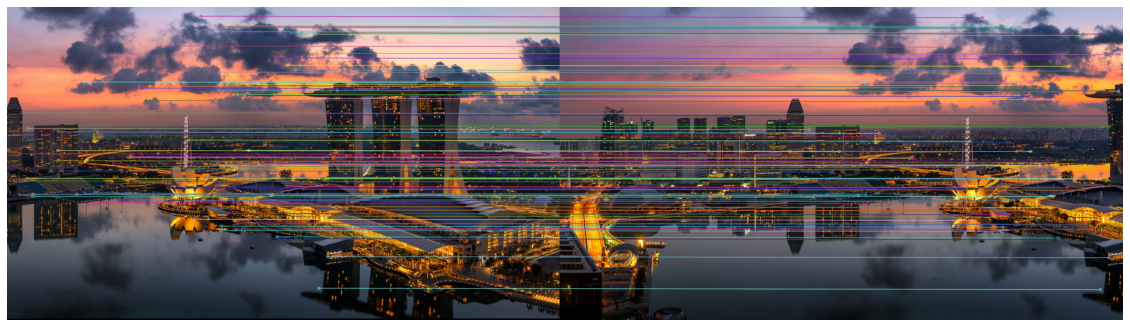

In [15]:
feature_to_match = 'knn'

print("Drawing: {} matched features Lines".format(feature_to_match))

fig = plt.figure(figsize=(20,8))

if feature_to_match == 'bf':
    matches = key_points_matching(feature_train_img, feature_query_img, method=feature_extraction_algo)
    
    mapped_features_image = cv2.drawMatches(train_photo,keypoints_train_img,query_photo,keypoints_query_img,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Now for cross checking draw the feature-mapping lines also with KNN
elif feature_to_match == 'knn':
    matches = key_points_matching_KNN(feature_train_img, feature_query_img, ratio=0.75, method=feature_extraction_algo)
    
    mapped_features_image_knn = cv2.drawMatches(train_photo, keypoints_train_img, query_photo, keypoints_query_img, np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(mapped_features_image_knn)
plt.axis('off')
plt.savefig("./output/" + feature_to_match + "_matching_img_"+'.jpeg', bbox_inches='tight', 
            dpi=300, optimize=True, format='jpeg')
plt.show()

In [17]:
def homography_stitching(keypoints_train_img, keypoints_query_img, matches, reprojThresh):
    """ converting the keypoints to numpy arrays before passing them for calculating Homography Matrix.
    
    Because we are supposed to pass 2 arrays of coordinates to cv2.findHomography, as in I have these points in image-1, and I have points in image-2, so now what is the homography matrix to transform the points from image 1 to image 2
    """
    keypoints_train_img = np.float32([keypoint.pt for keypoint in keypoints_train_img])
    keypoints_query_img = np.float32([keypoint.pt for keypoint in keypoints_query_img])
    
    ''' For findHomography() - I need to have an assumption of a minimum of correspondence points that are present between the 2 images. Here, I am assuming that Minimum Match Count to be 4 '''
    if len(matches) > 4:
        # construct the two sets of points
        points_train = np.float32([keypoints_train_img[m.queryIdx] for m in matches])
        points_query = np.float32([keypoints_query_img[m.trainIdx] for m in matches])
        
        # Calculate the homography between the sets of points
        (H, status) = cv2.findHomography(points_train, points_query, cv2.RANSAC, reprojThresh)

        return (matches, H, status)
    else:
        return None

In [18]:
M = homography_stitching(keypoints_train_img, keypoints_query_img, matches, reprojThresh=4)

if M is None:
    print("Error!")

(matches, Homography_Matrix, status) = M

print(Homography_Matrix)

[[ 1.00009538e+00 -5.60534748e-05  5.99010317e+02]
 [ 4.46370325e-05  1.00004715e+00  2.96564531e+00]
 [ 8.27670900e-08 -3.70054597e-08  1.00000000e+00]]


width  2922


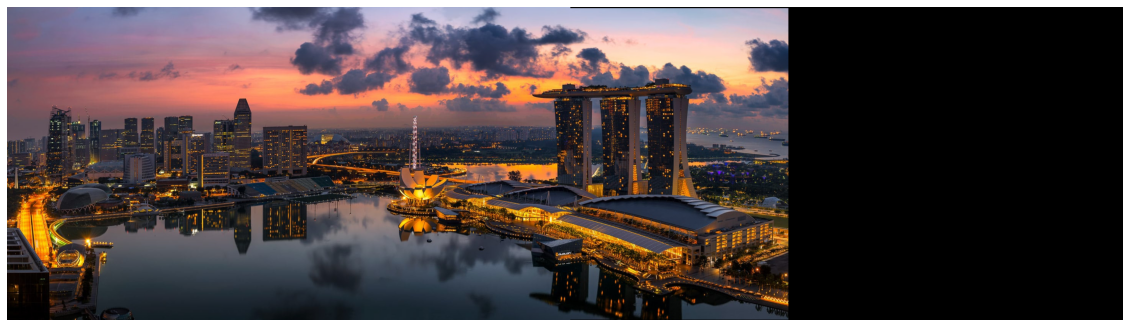

In [19]:
# For the calculation of the width and height of the final horizontal panoramic images 
# I can just add the widths of the individual images and for the height
# I can take the max from the 2 individual images.

width = query_photo.shape[1] + train_photo.shape[1]
print("width ", width) 
# 2922 - Which is exactly the sum value of the width of 
# my train.jpg and query.jpg


height = max(query_photo.shape[0], train_photo.shape[0])

# otherwise, apply a perspective warp to stitch the images together

# Now just plug that "Homography_Matrix"  into cv::warpedPerspective and I shall have a warped image1 into image2 frame

result = cv2.warpPerspective(train_photo, Homography_Matrix,  (width, height))

# The warpPerspective() function returns an image or video whose size is the same as the size of the original image or video. Hence set the pixels as per my query_photo

result[0:query_photo.shape[0], 0:query_photo.shape[1]] = query_photo

plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(result)

imageio.imwrite("./output/horizontal_panorama_img_"+'.jpeg', result)

plt.show()